**OBJECTIVE:** Run modSAR algorithm on QSAR datasets 

In [4]:
import math
import numpy as np
import pandas as pd

# Import relevant modSAR classes 
from modSAR.network_algorithms import ModSAR
from modSAR.cdk_utils import CDKUtils
from modSAR.datasource import GenericFileDataSource
from modSAR.preprocessing import *
from modSAR.dataset import QSARDataset, QSARDatasetIO

from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Geometry
from rdkit.Chem import rdFMCS
from rdkit.Chem.Draw import IPythonConsole 

#from gevent import monkey
#monkey.patch_all()

# 2.5uM in Log units
CUTOFF_ACTIVITY = - np.log10(2.5e-06)

%matplotlib inline

# Load Data

In [9]:
osm4_dataset = \
    QSARDatasetIO.load(dataset_name='OSM4',
                   activity_sheetname='activity',
                   smiles_column='Canonical_Smiles',
                   id_column='OSM_ID',
                   filepath='/mnt/data/OSM-S4/osm4_qsardataset.xls',
                   calculate_similarity=False)
    
similarity_matrix = pd.read_csv('/mnt/data/OSM-S4/similarity_values.csv', index_col='OSM_ID')
    
osm4_dataset

QSARDataset OSM4 
 -- Samples : 347
 -- Features:  1024

In [10]:
similarity_matrix.shape

(347, 347)

## Manually remove invalid entries

There were three entries (rows) with NaN values:

In [11]:
sum(osm4_dataset.X.isnull().sum(axis=1) > 0)

0

In [12]:
invalid_entries = osm4_dataset.X.index[osm4_dataset.X.isnull().sum(axis=1) > 0]
invalid_entries

Index([], dtype='object', name='OSM_ID')

In [13]:
osm4_dataset.X = osm4_dataset.X.drop(invalid_entries)
osm4_dataset.X_norm = osm4_dataset.X_norm.drop(invalid_entries)
osm4_dataset.y = osm4_dataset.y.drop(invalid_entries)
osm4_dataset.metadata = osm4_dataset.metadata.drop(invalid_entries)
osm4_dataset.number_samples = osm4_dataset.X.shape[0]

similarity_matrix = similarity_matrix.drop(invalid_entries)
similarity_matrix = similarity_matrix.drop(columns=invalid_entries)

osm4_dataset

QSARDataset OSM4 
 -- Samples : 347
 -- Features:  1024

In [14]:
similarity_matrix.shape

(347, 347)

# Run ModSAR algorithm

Create an instance of modSAR algorithm and run `<ModSAR obj>.fit()` function with molecular descriptors, outcome variable and pairwise similarity:

In [8]:
#osm4_dataset.y[osm4_dataset.y <= CUTOFF_ACTIVITY] = CUTOFF_ACTIVITY

In [ ]:
alg = ModSAR(lam=0.005)

alg.fit(osm4_dataset.X_norm, osm4_dataset.y, 
        similarity_matrix.values, 
        osm4_dataset.metadata.Canonical_Smiles)

ModSAR(beta=0.03, epsilon=0.01, lam=0.005, solver_name='cplex')
Best Threshold = 0.20 | ACC = 0.891
Threshold: 0.2 | k: 0
Communities: Counter({'m02': 206, 'm01': 52, 'm03': 52, 'm04': 37})
Num. samples in comm m01: 52
OplraRegularised(beta=0.03, epsilon=0.01, exact_number_regions=None,
         lam=0.005, solver_name='cplex')
########## R = 1
SELECTED FEATURES:
['Bit_0025', 'Bit_0045', 'Bit_0065', 'Bit_0131', 'Bit_0145', 'Bit_0147', 'Bit_0150', 'Bit_0175', 'Bit_0187', 'Bit_0193', 'Bit_0199', 'Bit_0230', 'Bit_0236', 'Bit_0305', 'Bit_0316', 'Bit_0345', 'Bit_0350', 'Bit_0360', 'Bit_0377', 'Bit_0392', 'Bit_0393', 'Bit_0405', 'Bit_0406', 'Bit_0412', 'Bit_0429', 'Bit_0452', 'Bit_0470', 'Bit_0542', 'Bit_0567', 'Bit_0570', 'Bit_0609', 'Bit_0611', 'Bit_0614', 'Bit_0626', 'Bit_0648', 'Bit_0669', 'Bit_0674', 'Bit_0678', 'Bit_0688', 'Bit_0694', 'Bit_0704', 'Bit_0743', 'Bit_0746', 'Bit_0747', 'Bit_0753', 'Bit_0780', 'Bit_0788', 'Bit_0795', 'Bit_0799', 'Bit_0826', 'Bit_0874', 'Bit_0878', 'Bit_0889'

In [10]:
# osm4_dataset.metadata

In [11]:
y_predicted = alg.predict(osm4_dataset.X_norm, osm4_dataset.metadata.Canonical_Smiles)

In [12]:
from sklearn.metrics import mean_absolute_error, r2_score

In [13]:
mean_absolute_error(osm4_dataset.y, y_predicted)

0.17916394642815386

In [14]:
r2_score(osm4_dataset.y, y_predicted)

0.48663233606090661

In [15]:
from sklearn.externals import joblib
alg.fingerprints_training = None
joblib.dump(alg, filename='/mnt/data/OSM-S4/modsar_model.joblib')

# alg = joblib.load('/mnt/data/OSM-S4/modsar_model.joblib')

['/mnt/data/OSM-S4/modsar_model.joblib']

## Graph

We can investigate characteristics of the graph created by modSAR by inspecting the `<modSAR obj>.instance_graph` object:

In [16]:
alg.threshold

0.20000000000000001

In [17]:
graph = alg.instance_graph

In [18]:
graph.vs['Series'] = osm4_dataset.metadata['Series'].values

In [19]:
print(graph)

IGRAPH U--- 345 28049 --
+ attr: globalClusteringCoefficient (g), k (g), threshold (g), SMILES (v),
  Series (v), community (v), degree (v), label (v), louvain (v)
+ edges:
  0 --   1   2   3   4  11  12  13  14  15  16  17  18  19  20  21  23  24  25
26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  45  46
48  49  50  51  55  58  66  75
  1 --   0   2   3   4  11  12  13  14  15  16  17  18  19  20  21  23  24  25
26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
46  47  48  49  50  51 109 119 166 196 197 315
  2 --   0   1   3   4  11  12  13  14  15  16  17  18  19  20  21  23  24  25
26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
46  47  49  50  51 271
  3 --   0   1   2   4   5   6   7   8   9  10  11  12  14  16  20  21  23  24
25  26  27  28  29  30  31  32  33  34  35  36  37  38  40  41  43  44  45  46
47  48  49  50  51 306
  4 --   0   1   2   3   5   6   7   8   9  10  11  12  14  16  17  19 

Largest modules:

In [20]:
module_sizes = pd.Series(alg.instance_graph.vs['community']).value_counts()
module_sizes.head(15)

m02    207
m01     52
m03     49
m04     37
dtype: int64

In [21]:
singletons = module_sizes.index[module_sizes == 1]
non_singletons = module_sizes.index[module_sizes != 1]
singletons

Index([], dtype='object')

In [22]:
non_singletons

Index(['m02', 'm01', 'm03', 'm04'], dtype='object')

In [23]:
graph.save("/mnt/data/osm_s4_graph.graphml")

## Piecewise models

Every module in the graph (m01, m02, m03, etc.) is predicted by a piecewise model that we can uncover from the `<modSAR obj>.get_model_info()` function.

The function returns the linear coefficients and breakpoints used to split the data into regions.

In [24]:
coeff, breakpoints = alg.get_model_info()

In [26]:
breakpoints

,module,region,breakpoints,fStar
0,m01,0,0.74,khs.dssC
1,m01,1,0.77,khs.dssC
2,m04,0,0.116076,MDEO-22
3,m04,1,0.280651,MDEO-22
4,m03,0,None,None
5,m02,0,0.26,C3SP2


In [27]:
coeff

,module,region,khs.dsCH,khs.sOH,BCUTw-1l,BCUTc-1l,nAtomP,MDEO-12,khs.sCH3,khs.tsC,khs.ssNH,khs.sF,C2SP3,ATSm1,nHBDon,BCUTp-1h,MDEO-22,khs.aaaC,khs.ssssC,khs.sNH2,khs.sssN,khs.sCl,SC-3,SC-4,SC-5,C3SP2,ATSc3,ATSc4,nHBAcc,B
0,m01,0,0.145365,0.096910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.602060
1,m01,1,0.000000,0.000000,0.150020,-0.292369,-0.366129,-2.157032,1.798849,-0.760702,3.765629,2.067507,0.428265,0.560809,-2.478291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.910419
2,m01,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.915910,2.371666,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.031444
3,m04,0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.602060
4,m04,1,NaN,NaN,-0.463936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.032452
5,m04,2,NaN,NaN,-0.039866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.869666
6,m03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.602060
7,m02,0,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.602060
8,m02,1,NaN,0.033369,NaN,NaN,NaN,0.111342,NaN,NaN,NaN,0.424778,NaN,NaN,NaN,-0.079013,0.607733,0.297447,0.024648,-0.122827,-0.358393,0.310443,0.031647,0.193502,0.208097,0.235271,-0.315088,0.341148,-1.003103,5.657645


# Analysis of Modules

## Module 02


Module m02 is where most OSM-S4 are (Gephi anaylisis). It is described by two regions:

$1. \text{C3SP2} \le 0.26$

$2. \text{C3SP2} > 0.26$

In [28]:
def print_module_equations(coeffs, module):
    """Helper function to print a clean representation of piecewise equations for informed module"""
    
    coeffs = coeffs.query('module == "%s"' % module)

    def get_linear_equation(row):
        coeffs = ['%+.2f %s' % (val, coeff) for coeff, val in row.iteritems() 
                  if not (math.isnan(val) or float(val) == 0) and coeff != 'B']
        equation_str = ' '.join(coeffs)
        equation_str += " %+.2f" % row['B']    
        return equation_str  
    
    for idx, row in coeffs.groupby(['module', 'region']):
        equation = get_linear_equation(row.drop(columns=['module', 'region']))
        print('Equqations for Module %s | Region %d\n' % idx)
        print("pIC50 = ", equation)
        print()

In [29]:
print_module_equations(coeff, 'm02')

Equqations for Module m02 | Region 0

pIC50 =   +5.60

Equqations for Module m02 | Region 1

pIC50 =  +0.03 khs.sOH +0.11 MDEO-12 +0.42 khs.sF -0.08 BCUTp-1h +0.61 MDEO-22 +0.30 khs.aaaC +0.02 khs.ssssC -0.12 khs.sNH2 -0.36 khs.sssN +0.31 khs.sCl +0.03 SC-3 +0.19 SC-4 +0.21 SC-5 +0.24 C3SP2 -0.32 ATSc3 +0.34 ATSc4 -1.00 nHBAcc +5.66



### Structural Similarity

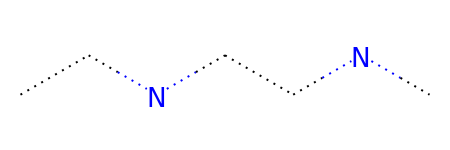

In [30]:
idx_mols_in_m02 = np.where(np.array(alg.instance_graph.vs['community']) == 'm02')[0]
region01 = idx_mols_in_m02[osm4_dataset.X_norm.iloc[idx_mols_in_m02]['C3SP2'] < 0.26] 
region02 = idx_mols_in_m02[(osm4_dataset.X_norm.iloc[idx_mols_in_m02]['nHBDon'] > 0.26)]

smiles_m02 = osm4_dataset.metadata.Canonical_Smiles.iloc[region01]

res = rdFMCS.FindMCS([Chem.MolFromSmiles(mol) for mol in smiles_m02])
pattern = Chem.MolFromSmarts(res.smartsString)
pattern

In [31]:
graph.vs['activity'] = osm4_dataset.y['pIC50'].values
graph.vs['C3SP2'] = osm4_dataset.X_norm['C3SP2'].values

In [ ]:
graph.write_gml('/mnt/data/OSM-S4/osm-s4-graph.gml')

### Most representative structure (region 01)

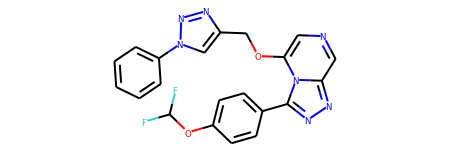

In [32]:
degrees = np.array([alg.instance_graph.vs[i]['degree'] for i in region01])
most_representative = osm4_dataset.metadata.Canonical_Smiles.iloc[region01[np.argmax(degrees)]]
Chem.MolFromSmiles(most_representative)

### Most representative structure (region 02)

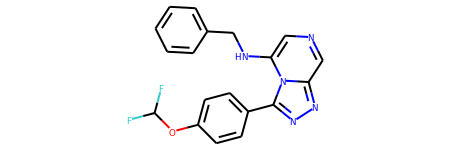

In [33]:
degrees = np.array([alg.instance_graph.vs[i]['degree'] for i in region02])
most_representative = osm4_dataset.metadata.Canonical_Smiles.iloc[region02[np.argmax(degrees)]]
Chem.MolFromSmiles(most_representative)

# Test Set

Predict samples in test set

In [34]:
test_set = pd.read_excel('/mnt/data/OSM-S4/Round 2 Test Set.xlsx')
test_set.shape

(34, 5)

In [35]:
test_set.set_index('OSM Code', inplace=True)

## Calculate Molecular Descriptors

- Calculate descriptors
- Select only those used by model

In [36]:
cdk_utils = CDKUtils()
test_set_descriptors = cdk_utils.calculate_descriptors(test_set, "SMILES")

(01/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WHIMDescriptor()
(02/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.BCUTDescriptor()
(03/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.XLogPDescriptor()
(04/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.WeightDescriptor()
(05/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RuleOfFiveDescriptor()
(06/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.RotatableBondsCountDescriptor()
(07/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.MannholdLogPDescriptor()
(08/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestPiSystemDescriptor()
(09/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.LargestChainDescriptor()
(10/49) Collecting descriptors from class self.cdk.qsar.descriptors.molecular.BondCountDescrip

In [37]:
test_set_descriptors.index = test_set.index

In [38]:
selected_idx = np.where(test_set_descriptors.iloc[0,].isnull() > 0)[0].tolist()
for i in selected_idx:
    test_set_descriptors.iloc[0, i] = test_set_descriptors.iloc[1, i]

In [42]:
#test_set_descriptors.drop(columns=selected_idx, inplace=True)

## Apply modSAR

In [60]:
pred_IC50_modsar = alg.predict(test_set_descriptors[osm4_dataset.X.columns], test_set['SMILES'])
pred_IC50_modsar = pd.DataFrame(pred_IC50_modsar)
pred_IC50_modsar.columns = ["pIC50"]
pred_IC50_modsar.index = test_set['SMILES'].values

pred_IC50_modsar['prediction (uM)'] = pred_IC50_modsar["pIC50"].apply(lambda x: math.pow(10, -x,)/(1e-6))
pred_IC50_modsar

,pIC50,prediction (uM)
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCCC4567[BH]89%10[BH]%11%124[BH]8%13%14[BH]%11%15%16[CH]%13%17%18[BH]%149%19[BH]%105%20[BH]%21%226[BH]%17%15([BH]%22%12%167)[BH]%18%19%20%21)N32,5.602060,2.500000
FC(F)C1(C2)CC2(COC3=CN=CC4=NN=C(C5=CC=C(OC(F)F)C=C5)N43)C1,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=CC=C4)N32,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=C(F)C=C4F)N32,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=C(F)C(F)=C4)N32,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC(C(F)(F)F)=CC=C4)N32,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(OC)C=CC=C4)N32,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC(OC)=CC=C4)N32,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC=C(OC)C=C4)N32,5.602060,2.500000
FC(F)OC(C=C1)=CC=C1C2=NN=C3C(OCC(CO)C4=CC=CC=C4)=NC=CN32,5.602060,2.500000


## Apply RF

In [83]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(osm4_dataset.X, osm4_dataset.y)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
pred_IC50 = pd.Series(rf.predict(test_set_descriptors[osm4_dataset.X.columns]), name='pIC50')
pred_IC50.index = test_set['SMILES'].index

In [116]:
result = pd.concat([test_set['SMILES'], pred_IC50], axis=1)
result['prediction modSAR-Random Forest (uM)'] = result.apply(lambda x: math.pow(10, -x['pIC50'],)/(1e-6), axis=1)

In [117]:
result

,SMILES,pIC50,prediction modSAR-Random Forest (uM)
OSM Code,,,
OSM-LO-1,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCCC4567[BH]...,5.777914,1.667577
OSM-S-690,FC(F)C1(C2)CC2(COC3=CN=CC4=NN=C(C5=CC=C(OC(F)F...,5.703730,1.978200
OSM-LO-2,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.834885,1.462564
OSM-LO-7,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.942085,1.142655
OSM-LO-8,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.939529,1.149399
OSM-LO-6,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.879416,1.320030
OSM-LO-4,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.925896,1.186053
OSM-LO-5,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.887744,1.294960
OSM-LO-10,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.849382,1.414549


In [90]:
from rdkit.Chem import PandasTools

In [118]:
experimental_vals = [2, 2.63, 0.159, 0.89, 0.19, 0.094, 0.304, 0.124, 0.722, 9.538, 9.69, 25, 9.94, 0.605, 1.06, 4.57, 4.23, 25, 16.17, 7.81, 25, 17.02, 0.367, 1.71, 14.25, 25, 25, 25, 25, 10.13, 1.25, 9.94, 14.55, 25]
result["Experimental (uM)"] = experimental_vals

In [119]:
result

,SMILES,pIC50,prediction modSAR-Random Forest (uM),Experimental (uM)
OSM Code,,,,
OSM-LO-1,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCCC4567[BH]...,5.777914,1.667577,2.000
OSM-S-690,FC(F)C1(C2)CC2(COC3=CN=CC4=NN=C(C5=CC=C(OC(F)F...,5.703730,1.978200,2.630
OSM-LO-2,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.834885,1.462564,0.159
OSM-LO-7,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.942085,1.142655,0.890
OSM-LO-8,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.939529,1.149399,0.190
OSM-LO-6,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.879416,1.320030,0.094
OSM-LO-4,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,5.925896,1.186053,0.304
OSM-LO-5,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.887744,1.294960,0.124
OSM-LO-10,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,5.849382,1.414549,0.722


In [120]:
sim = result.drop(columns=["pIC50"]).copy()

PandasTools.AddMoleculeColumnToFrame(sim, "SMILES", "Molecule")
# print(sim.to_latex())

RDKit ERROR: [22:26:30] Explicit valence for atom # 21 C, 6, is greater than permitted


,SMILES,prediction modSAR-Random Forest (uM),Experimental (uM),Molecule
OSM Code,,,,
OSM-LO-1,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCCC4567[BH]...,1.667577,2.000,None
OSM-S-690,FC(F)C1(C2)CC2(COC3=CN=CC4=NN=C(C5=CC=C(OC(F)F...,1.978200,2.630,
OSM-LO-2,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,1.462564,0.159,
OSM-LO-7,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,1.142655,0.890,
OSM-LO-8,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,1.149399,0.190,
OSM-LO-6,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,1.320030,0.094,
OSM-LO-4,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(...,1.186053,0.304,
OSM-LO-5,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,1.294960,0.124,
OSM-LO-10,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC...,1.414549,0.722,

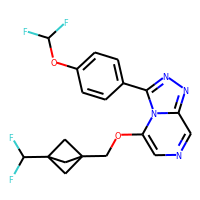
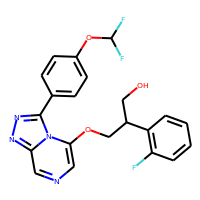
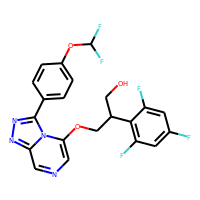
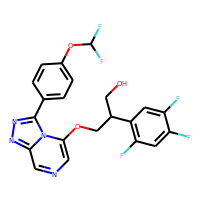
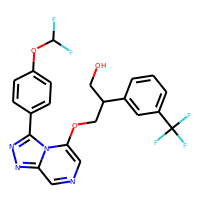
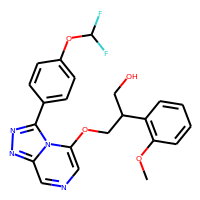
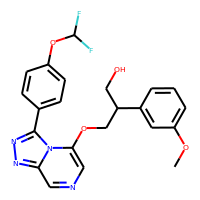
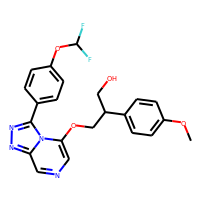
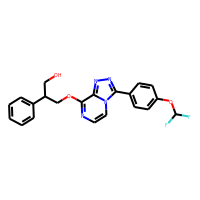
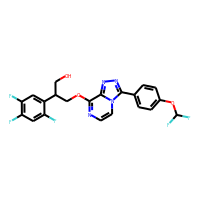
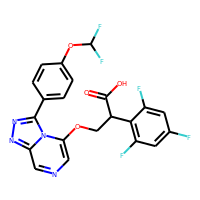
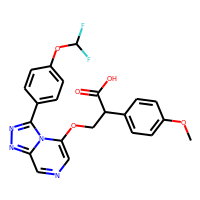
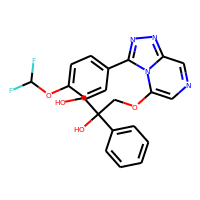
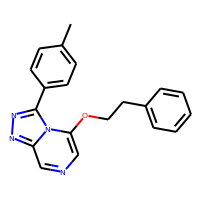
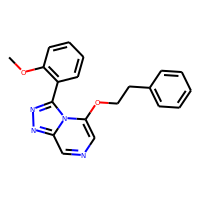
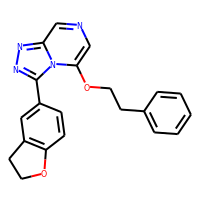
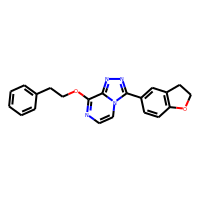
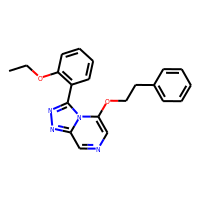
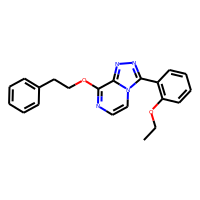
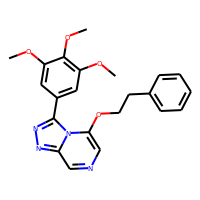
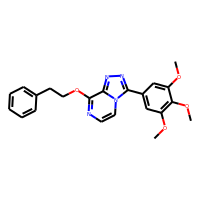
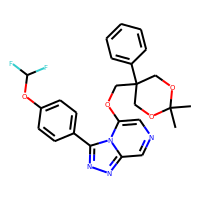
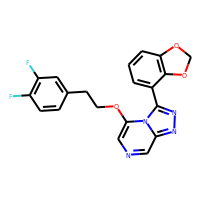
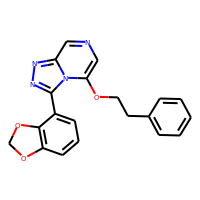
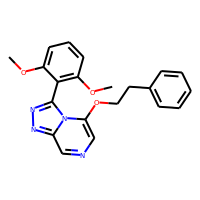
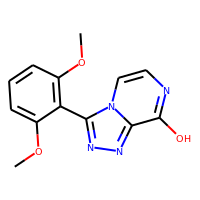
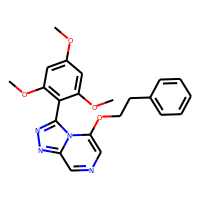
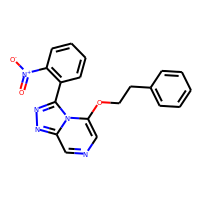
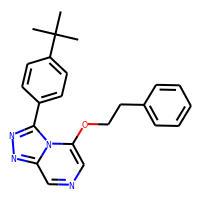
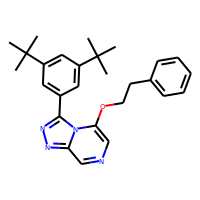
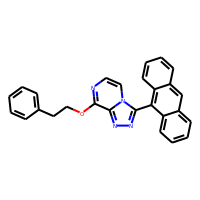
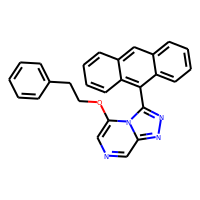
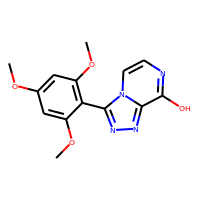

In [121]:
sim

In [ ]:
result.to_csv('/mnt/data/OSM-S4/submission-jonathan-cardoso-silva-rf.csv')

## RF on the modules

Instead of OPLRAreg, use RF on the modules

In [61]:
from collections import Counter

def classify_sample(alg, sample_smiles, cdk_utils=None):
    """"""

    if cdk_utils is None:
        cdk_utils = CDKUtils()

    fp_sample = cdk_utils.calculate_fingerprint(sample_smiles)

    if alg.fingerprints_training is None:
        print("Recalculating fingerprints for samples in the graph.")
        alg.fingerprints_training = [cdk_utils.calculate_fingerprint(smiles)
                                      for smiles in alg.instance_graph.vs['SMILES']]

    similarities = [cdk_utils.cdk.similarity.Tanimoto.calculate(fp_sample, fp_training)
                    for fp_training in alg.fingerprints_training]
    similarities = np.array(similarities)

    neighbours = np.argwhere(similarities >= alg.threshold).flatten()
    if len(neighbours) <= 1:
        neighbours = np.array([similarities.argmax()])

    modules_training = np.array(alg.instance_graph.vs["community"])
    neighbours_modules = Counter(modules_training[neighbours])
    # Maximum number of links to a module
    max_links = neighbours_modules.most_common(1)[0][1]
    max_modules = [k for k, v in neighbours_modules.items() if v == max_links]
    
    if len(max_modules) == 1:
        comm = max_modules[0]
        dist_to_modules = {comm: np.average(similarities[np.argwhere(modules_training == comm).flatten()])}
    else:
        dist_to_modules = {comm: np.average(similarities[np.argwhere(modules_training == comm).flatten()])
                           for comm in max_modules}
    closest_module = max(dist_to_modules, key=lambda x: dist_to_modules[x])
    return closest_module

In [62]:
pd.Series([classify_sample(alg, mol) for mol in test_set['SMILES']]).value_counts()

m02    32
m04     2
dtype: int64

### RF on module m02

In [63]:
from sklearn.ensemble import RandomForestRegressor

idx_mols_in_m02 = np.where(np.array(alg.instance_graph.vs['community']) == 'm02')[0]

rf_m02 = RandomForestRegressor(n_estimators=100)
rf_m02.fit(osm4_dataset.X.iloc[idx_mols_in_m02], osm4_dataset.y.iloc[idx_mols_in_m02])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### RF on module m04

In [64]:
idx_mols_in_m04 = np.where(np.array(alg.instance_graph.vs['community']) == 'm04')[0]

rf_m04 = RandomForestRegressor(n_estimators=100)
rf_m04.fit(osm4_dataset.X.iloc[idx_mols_in_m04], osm4_dataset.y.iloc[idx_mols_in_m04])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [76]:
def apply_custom_rf(df):
    
    # Check which module the module belongs to
    
    module = classify_sample(alg, df['SMILES'])
    row = df.drop(['SMILES']).to_frame().transpose()
    
    if module == 'm02':
        result = rf_m02.predict(row)
    elif module == 'm04':
        result = rf_m04.predict(row)

    return result[0]

predIC50 = pd.concat([test_set_descriptors[osm4_dataset.X.columns], test_set['SMILES']], axis=1)\
                .apply(apply_custom_rf, axis=1)
predIC50 = pd.DataFrame(predIC50, columns=['pIC50'])

In [79]:
result = pd.concat([test_set['SMILES'], predIC50], axis=1)
result['prediction (uM)'] = result.apply(lambda x: math.pow(10, -x['pIC50'],)/(1e-6), axis=1)
result['prediction (uM)']

OSM Code
OSM-LO-1     1.586549
OSM-S-690    1.800148
OSM-LO-2     1.436184
OSM-LO-7     1.220496
OSM-LO-8     1.209091
OSM-LO-6     1.220876
OSM-LO-4     1.309433
OSM-LO-5     1.323616
OSM-LO-10    1.416339
OSM-LO-14    0.918452
OSM-LO-9     1.097837
OSM-LO-11    1.274509
OSM-LO-12    1.213434
OSM-S-556    0.489394
OSM-S-666    1.640923
OSM-S-670    1.823936
OSM-S-668    1.255447
OSM-S-669    1.536079
OSM-S-672    1.604240
OSM-S-673    1.794185
OSM-S-675    1.376575
OSM-S-676    1.401747
OSM-S-651    1.075272
OSM-S-662    1.587444
OSM-S-693    1.226770
OSM-S-687    1.325784
OSM-S-694    1.878750
OSM-S-689    1.262265
OSM-S-678    2.036274
OSM-S-683    0.968649
OMS-S-685    0.833105
OSM-S-691    0.853424
OSM-S-680    0.924001
OSM-S-692    0.714633
Name: prediction (uM), dtype: float64

In [ ]:
result.to_csv('/mnt/data/OSM-S4/submission-jonathan-cardoso-silva-modular-rf.csv')